### Extracting data from the JSON files

In [14]:
DATA_SIZE = 1569264
SAMPLE_SIZE = 150000
TRAIN_SIZE = 10000
GOAL = 10000
CUTOFF = 3
MIN_LENGTH = 200

In [15]:
import numpy as np
import json 
import pandas

In [16]:
business_ratings = { }
for line in open("data/yelp_academic_dataset_business.json", "r"):
    json_data = json.loads(line)
    business_ratings[json_data["business_id"]] = json_data["stars"]
#selected_businesses = set(np.random.choice(business_ratings.keys(), size = 2000, replace = False))
    
review_list = []

selected = set(np.random.choice(np.arange(DATA_SIZE), size=SAMPLE_SIZE, replace=False))
positive = 0
negative = 0
short = 0
for line_num, line in enumerate(open("data/yelp_academic_dataset_review.json", "r")):
    if line_num in selected:
        json_data = json.loads(line)
        """
        if len(json_data["text"]) < MIN_LENGTH:
            short += 1
            continue
        """
        if (positive < GOAL and json_data["stars"] >= CUTOFF) or (negative < GOAL and json_data["stars"] < CUTOFF):
            review_list.append([json_data["review_id"], json_data["stars"], json_data["text"], json_data["business_id"]])
            if json_data["stars"] >= CUTOFF:
                positive += 1
            else:
                negative += 1
                
print short
review_pd = pandas.DataFrame(review_list, columns = ["Review ID", "Stars", "Review Text", "Business ID"])

0


### Tokenizing the review text

In [17]:
import sys
import string
import unicodedata

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode) if unicodedata.category(unichr(i)).startswith('P'))

def tokenize(text):
    return text.translate(tbl).lower().split()

review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)

In [18]:
review_pd.shape

(20000, 5)

In [19]:
%matplotlib inline
review_pd.groupby("Stars").count()

,Review ID,Review Text,Business ID,Tokenized Text
Stars,,,,
1,5211,5211,5211,5211
2,4789,4789,4789,4789
3,1846,1846,1846,1846
4,3729,3729,3729,3729
5,4425,4425,4425,4425


In [48]:
review_pd.to_json("data/review_binomial_cutoff_3_20k.json")

### Manipulating data into LabeledSentences

In [3]:
review_pd = pandas.read_json("data/review_binomial_cutoff_20k.json")

In [20]:
review_pd.groupby("Stars").count()

,Review ID,Review Text,Business ID,Tokenized Text
Stars,,,,
1,5211,5211,5211,5211
2,4789,4789,4789,4789
3,1846,1846,1846,1846
4,3729,3729,3729,3729
5,4425,4425,4425,4425


In [21]:
from gensim.models.doc2vec import LabeledSentence
import numpy as np

class LabeledSentences:
    
    def __init__(self, series):
        self.series = series
        
    def __iter__(self):
        indexes = list(np.arange(len(self.series)))
        np.random.shuffle(indexes)
        for (index, wordlist) in self.series.iloc[indexes].iteritems():
        #for (index, wordlist) in self.series.iteritems():
            yield LabeledSentence(words = wordlist, tags = ['VEC_%s' % index])
            
sentences = LabeledSentences(review_pd["Tokenized Text"].copy())

### Learn vector representations for each word via Word2Vec

In [40]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be slow otherwise"
cores = multiprocessing.cpu_count()

model1 = Doc2Vec(dm = 1, dm_concat = 0, min_count = 1, window = 10, size = 600, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model1.build_vocab(sentences)

model2 = Doc2Vec(dm = 0, dm_concat = 0, min_count = 1, window = 10, size = 600, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model2.build_vocab(sentences)

### Learn vector representations for each review text via Doc2Vec

In [41]:
for epoch in range(10):
    model1.train(sentences)
    model2.train(sentences)
    #model.alpha -= 0.002
    #model.min_alpha = model.alpha
    print 'Done %d' % (epoch)

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9


In [42]:
model1.most_similar('terrible')

[(u'horrible', 0.3424021601676941),
 (u'bacaros', 0.2761635184288025),
 (u'horrendous', 0.27532607316970825),
 (u'crappy', 0.2625032067298889),
 (u'horrid', 0.2509114146232605),
 (u'soonest', 0.2498949021100998),
 (u'poor', 0.24179193377494812),
 (u'awful', 0.23892655968666077),
 (u'bad', 0.23692214488983154),
 (u'atrocious', 0.23541006445884705)]

In [43]:
model2.most_similar('amazing')

[(u'weekendall', 0.16518330574035645),
 (u'hint', 0.1626659333705902),
 (u'eachas', 0.16265633702278137),
 (u'carbuying', 0.15536731481552124),
 (u'minimums', 0.15392491221427917),
 (u'fecies', 0.1531776785850525),
 (u'ernesto', 0.1523200273513794),
 (u'fireballs', 0.15089063346385956),
 (u'boogersmucus', 0.15062180161476135),
 (u'190', 0.14915722608566284)]

### Concatenate Review Rating with Vector

In [26]:
len(model1.docvecs)

20000

In [13]:
type(model1.docvecs)

gensim.models.doc2vec.DocvecsArray

In [44]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

train_indices = set(np.random.choice(np.arange(len(model1.docvecs)), replace=False, size=TRAIN_SIZE))

for index in xrange(len(model1.docvecs)):
    key = ("VEC_%s") % (index)
    
    if index in train_indices:
        design_matrix.append(np.append(model1.docvecs[key], model2.docvecs[key]))
        #design_matrix.append(model2.docvecs[key])
        labels.append(review_pd["Stars"][index])
        #labels.append(business_ratings[review_pd["Business ID"][index]])
    else:
        test_matrix.append(np.append(model1.docvecs[key], model2.docvecs[key]))
        #test_matrix.append(model2.docvecs[key])
        t_labels.append(review_pd["Stars"][index])
        #t_labels.append(business_ratings[review_pd["Business ID"][index]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels)
#labels = (np.array(labels) > 3).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels)
#t_labels = (np.array(t_labels) > 3).astype(int)

In [34]:
len(model1.docvecs)

20000

(array([    0.,     0.,   743.,     0.,   562.,     0.,   925.,     0.,
         1075.,     0.,  1195.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5]),
 <a list of 11 Patch objects>)

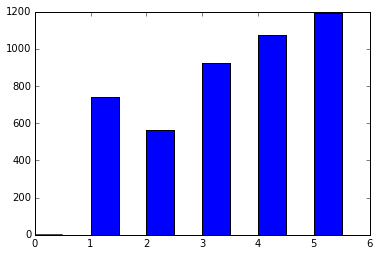

In [77]:
import matplotlib.pyplot as plt
plt.hist(labels,bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])

In [45]:
labels_binary = (labels >= CUTOFF).astype(int)
t_labels_binary = (t_labels >= CUTOFF).astype(int)

In [46]:
labels_binary.sum() * 1.0 / len(labels_binary)

0.49399999999999999

### Input data into Binomial Model

In [47]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression()
logreg.fit(design_matrix, labels_binary)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels_binary, preds)

0.8725


In [207]:

met.confusion_matrix(t_labels_binary, preds)

array([[ 9932,  2617],
       [ 2323, 10128]])

In [208]:
met.precision_score(t_labels_binary, preds)

0.79466457434287952

In [209]:
met.recall_score(t_labels_binary, preds)

0.81342864026985784

### Param tuning

In [51]:
s = 500
step = 100
accus = []

#train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))

while s < 1600:
    print "training: size = %s" % s 
    cores = multiprocessing.cpu_count()

    model1 = Doc2Vec(dm = 1, dm_concat = 0, min_count = 1, window = 12, size = s, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
    model1.build_vocab(sentences)

    model2 = Doc2Vec(dm = 0, dm_concat = 0, min_count = 1, window = 12, size = s, sample = 1e-4, negative = 5, 
                    workers = cores, alpha = 0.025, min_alpha = 0.025)
    model2.build_vocab(sentences)

    for epoch in range(10):
        model1.train(sentences)
        model2.train(sentences)
        print 'Done %d' % (epoch)
    
    design_matrix, labels = [], []
    test_matrix, t_labels = [], []

    # train_indices = set(np.random.choice(np.arange(len(model1.docvecs)), replace=False, size=TRAIN_SIZE))

    for index in xrange(len(model1.docvecs)):
        key = ("VEC_%s") % (index)

        if index in train_indices:
            design_matrix.append(np.append(model1.docvecs[key], model2.docvecs[key]))  
            labels.append(review_pd["Stars"][index])
        else:
            test_matrix.append(np.append(model1.docvecs[key], model2.docvecs[key]))
            t_labels.append(review_pd["Stars"][index])


    design_matrix = np.array(design_matrix)
    labels = np.array(labels)
    #labels = (np.array(labels) > 3).astype(int)

    test_matrix = np.array(test_matrix)
    t_labels = np.array(t_labels)
    
    labels_binary = (labels >= CUTOFF).astype(int)
    t_labels_binary = (t_labels >= CUTOFF).astype(int)
    
    logreg = LogisticRegression()
    logreg.fit(design_matrix, labels_binary)

    preds = logreg.predict(test_matrix)
    accus.append(met.accuracy_score(t_labels_binary, preds))
    
    print accus[-1]
    print
    s += step
    


training: size = 500
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8711

training: size = 600
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8723

training: size = 700
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8662

training: size = 800
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8732

training: size = 900
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8683

training: size = 1000
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8732

training: size = 1100
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8753

training: size = 1200
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8709

training: size = 1300
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.8679

training: size = 1400
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
0.868

traini

In [212]:
model.docvecs.most_similar('VEC_5')

[('VEC_13761', 0.6453726291656494),
 ('VEC_45409', 0.644080638885498),
 ('VEC_45423', 0.6431556940078735),
 ('VEC_46716', 0.6396288871765137),
 ('VEC_41644', 0.636633574962616),
 ('VEC_40546', 0.6356296539306641),
 ('VEC_30361', 0.6355552673339844),
 ('VEC_22352', 0.6353878974914551),
 ('VEC_27969', 0.633105993270874),
 ('VEC_41375', 0.6324337124824524)]

In [213]:
model.most_similar('busy')

[(u'hectic', 0.5573806762695312),
 (u'packed', 0.5284749269485474),
 (u'crowded', 0.5262379050254822),
 (u'overwhelmed', 0.4782603979110718),
 (u'busier', 0.4369233250617981),
 (u'swamped', 0.4319928288459778),
 (u'rudesnobby', 0.42692360281944275),
 (u'understaffed', 0.4239717125892639),
 (u'disorganized', 0.4195801615715027),
 (u'rushed', 0.4126394987106323)]

In [214]:
model.most_similar('service')

[(u'servicesome', 0.4910975396633148),
 (u'varity', 0.4837305545806885),
 (u'ambience', 0.48357269167900085),
 (u'consistently', 0.48040771484375),
 (u'staff', 0.4712163209915161),
 (u'sevice', 0.45872098207473755),
 (u'noisewasnt', 0.455005407333374),
 (u'waitstaff', 0.4481390118598938),
 (u'combogorgeous', 0.44679734110832214),
 (u'vick', 0.4416964650154114)]

### Input data into Multiclass Logistic Regression Model

In [70]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

star_mapping = { }
for index in xrange(0, 9):
    star_mapping[index * 0.5 + 1] = index

for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index < 45000:
        design_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        labels.append(star_mapping[business_ratings[review_pd["Business ID"][index]]])
    else:
        test_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        t_labels.append(star_mapping[business_ratings[review_pd["Business ID"][index]]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels).astype(int)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

logreg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs")
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print np.mean(abs(t_labels - preds))
print mean_squared_error(preds, t_labels) ** 0.5

1.06588176353
1.3910859932


(array([   62.,    72.,    93.,   316.,   882.,  1276.,  2403.,  1862.,
         1018.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

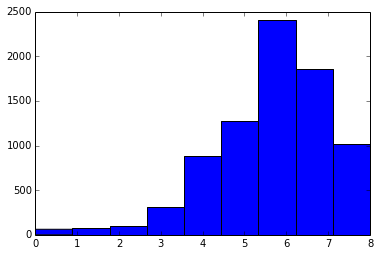

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(t_labels, bins = 9)

In [79]:
stars = np.array(business_ratings.values())
(stars == 3).sum()

8335